# Feedforward Neural Network

## Imports and Loading Dataset

In [107]:
!pip install numpy pandas matplotlib scikit-learn torch 


In [108]:
# --- Setup: Imports ---
import os, seaborn, sklearn, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim

# Scikit-learn imports
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
def print_system_info():
    print("="*60)
    print("SYSTEM INFORMATION")
    print("="*60)


    print(f"Operating System : {platform.system()} {platform.release()}")
    print(f"Processor        : {platform.processor()}")
    print(f"CPU Cores        : {psutil.cpu_count(logical=True)}")
    print(f"RAM              : {round(psutil.virtual_memory().total / (1024**3), 2)} GB")


    print(f"PC Username      : {getpass.getuser()}")


    print(f"Python Version   : {platform.python_version()}")
    print(f"Working Dir      : {os.getcwd()}")


    if torch.cuda.is_available():
        print(f"GPU Device       : {torch.cuda.get_device_name(0)}")
        print(f"CUDA Version     : {torch.version.cuda}")
    else:
        print("GPU Device       : None (CPU mode)")

    print("="*60)
    print()

print_system_info()


random_seed = 11
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

df = pd.read_csv('dataset/GHRP_dataset_csv/baseline.csv')

SYSTEM INFORMATION
Operating System : Darwin 23.6.0
Processor        : arm
CPU Cores        : 8
RAM              : 8.0 GB
PC Username      : mason
Python Version   : 3.12.12
Working Dir      : /Users/mason/4ML3/Bonus Project
GPU Device       : None (CPU mode)



## Formatting Data

In [109]:
raw_features = df.iloc[:, 1:-1].values.astype(float)
y = df.iloc[:,-1].values
test_size = 0.2
x_train, x_test,y_train,y_val = train_test_split(raw_features,y,test_size=test_size,random_state=42,stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)

X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_test)


print(f"Training features shape: {X_train_t.shape}")
print(f"Validation features shape: {X_val_t.shape}")


Training features shape: torch.Size([4841, 21])
Validation features shape: torch.Size([1211, 21])


## Model

In [110]:
class Net(nn.Module):

    def __init__(self, input_size,dropout_rate):
        super(Net, self).__init__()
        self.dropout_rate = dropout_rate
        self.input_size = input_size

        self.fc1 = nn.Linear(self.input_size, 32)

        self.fc2 = nn.Linear(32, 16)

        self.fc3 = nn.Linear(16,1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout()
        


    def forward(self, x):

        l1 = self.fc1(x)
        r1 = self.relu(l1)
        d1 = self.dropout(r1)


        l2 = self.fc2(d1)
        r2 = self.relu(l2)
        d2 = self.dropout(r2)
   

        l3 = self.fc3(d2)
        output = self.sigmoid(l3)


        
        return output
    
input_features = X_train_t.shape[1]
print(f"Model will accept {input_features} input features.")
print("--- 3. Model Class Defined ---")


Model will accept 21 input features.
--- 3. Model Class Defined ---


### Fully Connected Neural Network Shape
![FCNN](FFNN_Shape.jpg)

**After Relu activation in layers 1 and 2 a 50% dropout rate is applied**

## Training

Training is done via SGD minibatch using a BCE loss

In [ ]:
def train_with_minibatch(model, criterion, optimizer, X_train, y_train, X_val, y_val,
                         num_iterations, batch_size, l1_lambda):

    num_samples = X_train.shape[0]
    current_iteration = 0
    X_train_shuffled = X_train.clone()
    y_train_shuffled = y_train.clone()
    
    for i in range(num_iterations):
        if current_iteration+batch_size > num_samples:
            
            X_train_np, y_train_np = shuffle(X_train_shuffled.numpy(), y_train_shuffled.numpy())
            X_train_shuffled = torch.tensor(X_train_np, dtype=torch.float32)
            y_train_shuffled = torch.tensor(y_train_np, dtype=torch.float32)
            current_iteration = 0 
        
        
        xt_batch = X_train_shuffled[current_iteration : current_iteration+ batch_size]
        yt_batch = y_train_shuffled[current_iteration : current_iteration+ batch_size]

        current_iteration+=batch_size
        l1_norm = sum(p.abs().sum() for p in model.parameters())

        model.train()
        optimizer.zero_grad()
        t_pred = model(xt_batch)
        t_loss = criterion(t_pred,yt_batch) + l1_lambda*l1_norm
        t_loss.backward()
        optimizer.step()


    return model 

In [ ]:
def calculate_accuracy(model, X, y):

    model.eval()
    with torch.no_grad():

        outputs = model(X) 
        predictions = (outputs>=0.5).float() 
        accuracy = (predictions == y).float().mean() 


    return accuracy

In [ ]:

LAMBDA_L1_LIST = [0.001]
LEARNING_RATE_L1 = 0.01
NUM_ITERATIONS_L1 = 100000
BATCH_SIZE_L1 = 64
dropout_rate = 0.5

for LAMBDA_L1 in LAMBDA_L1_LIST:
    print(f"\n--- Training with L1 λ = {LAMBDA_L1} ---")
        
    y_train_t = torch.tensor(y_train).view(-1,1).float()
    y_val_t = torch.tensor(y_val).view(-1,1).float()

    model_l1 = Net(input_size=input_features,dropout_rate=dropout_rate)
    criterion = nn.BCELoss()
    optimizer_l1 =  torch.optim.SGD(model_l1.parameters(), lr=LEARNING_RATE_L1)


    model= train_with_minibatch(
        model_l1, criterion, optimizer_l1,
        X_train_t, y_train_t, X_val_t, y_val_t,
        NUM_ITERATIONS_L1, BATCH_SIZE_L1, LAMBDA_L1
    )

    final_accuracy_l1 = calculate_accuracy(model,X_val_t,y_val_t)

    print(f"Final Validation Accuracy (L1): {final_accuracy_l1*100:.2f}%")


--- Training with L1 λ = 0.001 ---
Percentage of predicted 1s: 55.66%
Final Validation Accuracy (L1): 75.81%


## Sparsity Representation
We chose to represent the sparsity of our neural network via the normalized sum of the first layer weights relevent to each input metric
- $w_{j,i}$ represents the *i*th weight of the *j*th input
- $s_j$ represents the sum of the weights of the *j*th input
$$s_j = \sum_{i=1}^n w_{j,i}$$
$$ W = \sum_{i=1,j=1}^{n,m}w_{j,i}$$
$$ns_j = \frac{s_j}{W}$$

**Essentailly we are representing the importance of each feature by their contribution to the total weight of the first layer**


### Feature Importance (L1 Sparsity Check) 
Metric Name | Standardized Weight Magnitude | Status 
 | :--- | :--- | :--- 
| totalFields | 0.7946 | Active Feature
| wmc | 0.0449 | Active Feature
| assignmentsQty | 0.0181 | Active Feature
| SHA | 0.0171 | Active Feature
| nosi | 0.0165 | Active Feature
| loopQty | 0.0153 | Active Feature
| variablesQty | 0.0127 | Active Feature
| numbersQty | 0.0111 | Active Feature
| loc | 0.0100 | Pruned (Little Impact)
| lcom | 0.0080 | Pruned (Little Impact)
| maxNestedBlocks | 0.0076 | Pruned (Little Impact)
| comparisonsQty | 0.0072 | Pruned (Little Impact)
| mathOperationsQty | 0.0066 | Pruned (Little Impact)
| stringLiteralsQty | 0.0062 | Pruned (Little Impact)
| dit | 0.0058 | Pruned (Little Impact)
| tryCatchQty | 0.0049 | Pruned (Little Impact)
| totalMethods | 0.0037 | Pruned (Little Impact)
| returnQty | 0.0035 | Pruned (Little Impact)
| cbo | 0.0028 | Pruned (Little Impact)
| parenthesizedExpsQty | 0.0019 | Pruned (Little Impact)
| rfc | 0.0016 | Pruned (Little Impact)


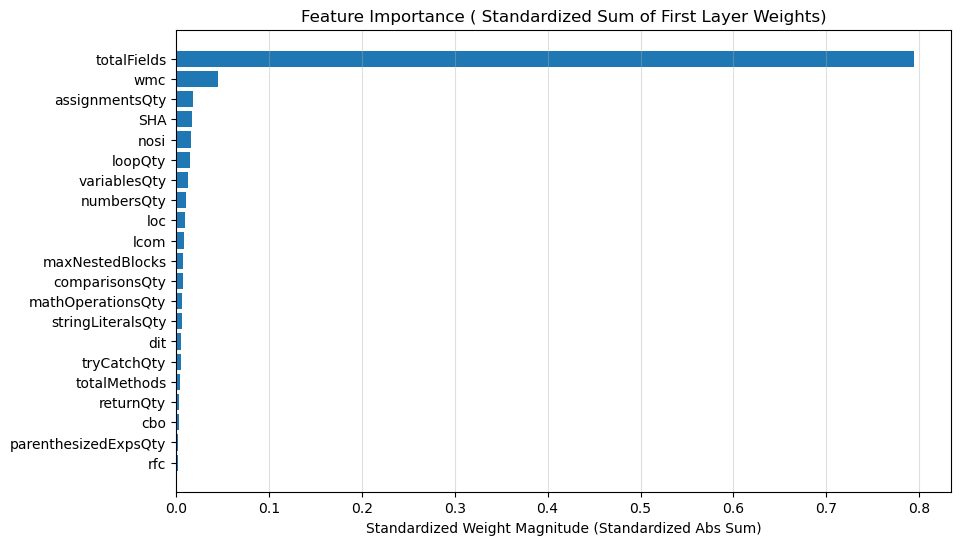

In [117]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown


first_layer_weights = next(model.parameters()).data.cpu()


weights = torch.sum(torch.abs(first_layer_weights), dim=0).numpy()

standard_weights = weights/(sum(weights)+1e-9)
feature_names = df.columns[:-1] 


importance = sorted(list(zip(feature_names, standard_weights)), key=lambda x: x[1], reverse=True)


md_table = '### Feature Importance (L1 Sparsity Check) \n'
md_table += 'Metric Name | Standardized Weight Magnitude | Status \n'
md_table += ' | :--- | :--- | :--- \n'

for name, weight in importance:

    
    if weight < 1e-2:
        impact = 'Pruned (Little Impact)' 
    else:
        impact = 'Active Feature'
        
    md_table += f"| {name} | {weight:.4f} | {impact}\n"

display(Markdown(md_table))

names_sorted = [name for name, _ in importance]
weights_sorted = [weight for _, weight in importance]

plt.figure(figsize=(10, 6))
plt.title('Feature Importance ( Standardized Sum of First Layer Weights)')
plt.xlabel("Standardized Weight Magnitude (Standardized Abs Sum)")
plt.grid(axis='x', alpha=0.4)


top_n = 30 
plt.barh(names_sorted[:top_n][::-1], weights_sorted[:top_n][::-1])
plt.show()